<a href="https://colab.research.google.com/github/akshatshah91/Game-AI/blob/master/Monte_Carlo_Tree_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import random
import math
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque
import sys

In [116]:
class Tree:
  def __init__(self, env, actionSize):
    self.env = copy.deepcopy(env)
    self.parent = None
    self.action = None
    self.children = {}
    for x in range(actionSize):
      self.children[x] = (False, None)
    self.state = None
    self.gameOver = None
    self.actionSize = actionSize
    self.visited = 0
    self.won = 0
    self.rewards = float("-inf")
    self.bestActions = []
  
  def isFullyExpanded(self):
    for x in range(self.actionSize):
      if self.children[x][0] is False:
        return False
    return True

  def chooseUntriedAction(self):
    actions = []
    for x in range(self.actionSize):
      if self.children[x][0] is False:
        actions.append(x)
    return random.choice(actions)
  
  def updateChildren(self,action, child):
    self.children[action] = (True, child)

In [119]:
def MCTS(env, s, actionSize, loops):
  root = Tree(env, actionSize)
  root.state = s
  for x in range(loops):
    v1 = treePolicy(root)
    reward,actions = defaultPolicy(v1)
    backup(v1, reward, actions)
  return root.bestActions

def treePolicy(v):
  while not v.gameOver:
    if not v.isFullyExpanded():
      return expand(v)
    v = bestChild(v)
  return v

def expand(v):
  action = v.chooseUntriedAction()
  v1 = Tree(v.env, v.actionSize)
  v1.parent = v
  v1.action = action
  v1.state,_,v1.gameOver,_ = v1.env.step(action)
  v.updateChildren(action, v1)
  return v1

def bestChild(v):
  c = None
  val = float('-inf')
  for _,(_,child) in v.children.items():
    if child is not None:
      calc = ((child.won/child.visited) + math.sqrt((2*math.log(v.visited))/child.visited))
      if calc > val:
        c = child
        val = calc
  return c

def defaultPolicy(v):
  state = copy.copy(v.state)
  env = copy.deepcopy(v.env)
  gameOver = v.gameOver
  reward = 0
  actions = []
  while not gameOver:
    action = np.random.randint(v.actionSize)
    state,r,gameOver,_ = env.step(action)
    reward += r
    actions.append(action)
  return reward,actions

def backup(v, r, actions):
  while v is not None:
    v.visited += 1
    v.won += r
    if v.rewards < r:
      v.rewards = r
      v.bestActions = copy.copy(actions)
      actions.insert(0, v.action)
    v = v.parent

In [104]:
def test(envName, episodes, loops=100):
  env = gym.make(envName)
  actionSize = env.action_space.n
  totalRewards = []
  for x in range(episodes):
    s = env.reset()
    actions = MCTS(env, s, actionSize, loops)
    gameOver = False
    reward = 0
    while not gameOver:
      s,r,gameOver,_ = env.step(actions[0])
      reward += r
      del(actions[0])
    totalRewards.append(reward)
  plt.plot(totalRewards)
  plt.title(envName)
  plt.show()
  print("")

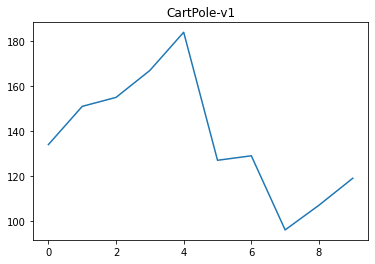

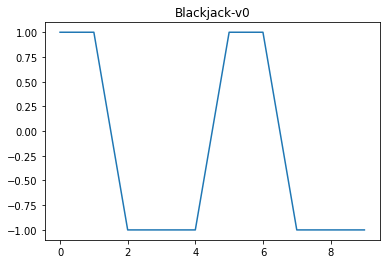

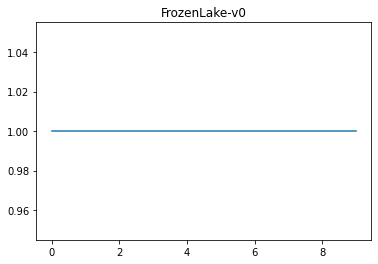

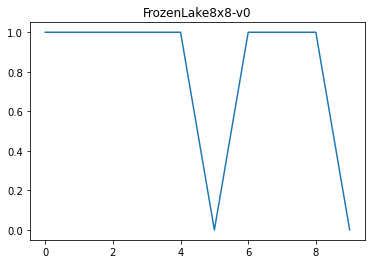

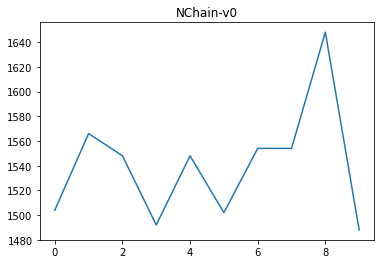

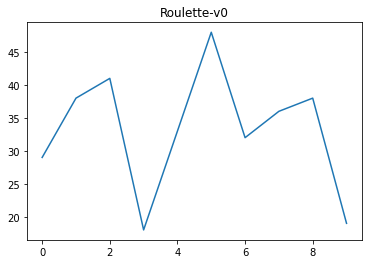

In [121]:
test("CartPole-v1",10,500)
test("Blackjack-v0",10,500)
test("FrozenLake-v0",10,500)
test("FrozenLake8x8-v0",10,500)
test("NChain-v0",10,100)
test("Roulette-v0",10,100)

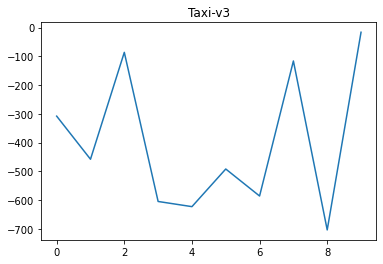

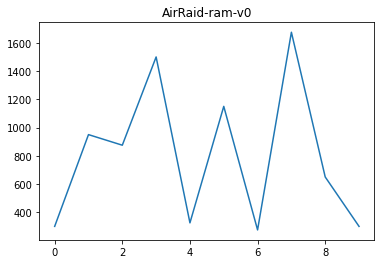

In [114]:
test("Taxi-v3",10,100)
test("AirRaid-ram-v0",10,100)

The Monte Carlo Tree Search algorithm gives really good results for some environments. I am getting a perfect score for FrozenLake, about 1500 for NChain, and between 400 and 1600 for AirRaid-ram. However, for some other environments it does not perform as well. For Taxi the average is about -400, but my regular Q-learning algorithm can get 10 as the average. Furthermore, my double DQN was getting on average 200 on CartPole but this is getting about 140. But it was also getting an average of 300 on AirRaid-ram so this outperformed.

Like with most algorithms, this will surely improve with more iterations. I believe the largest issue with this algorithm is the default policy. Due to its random nature it can go back to a previous state, which causes issues in environments like Taxi, where the less moves you make the better.